<a href="https://colab.research.google.com/github/FRANCIS-KHUSH/Craigslist-Vehicles-Time-Series-Model/blob/main/Predicting_Loan_Default_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
# Importing libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data
df = pd.read_csv('/content/drive/MyDrive//Loan_Default.csv')
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [ ]:
df.isnull().sum() / len(df) * 100

,0
ID,0.000000
year,0.000000
loan_limit,2.249277
Gender,0.000000
approv_in_adv,0.610749
loan_type,0.000000
loan_purpose,0.090133
Credit_Worthiness,0.000000
open_credit,0.000000
business_or_commercial,0.000000


# Visualization

<Axes: xlabel='Status', ylabel='count'>

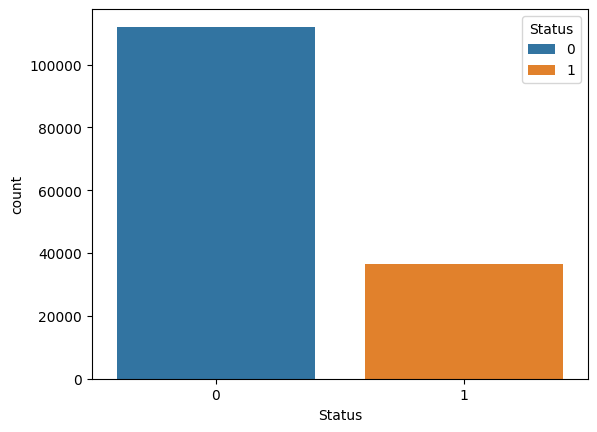

In [ ]:
# Count plot for Loan Status
sns.countplot(data=df, x='Status', hue='Status')

# Preprocessing

In [ ]:
df.select_dtypes(include=['object']).nunique()

,0
loan_limit,2
Gender,4
approv_in_adv,2
loan_type,3
loan_purpose,4
Credit_Worthiness,2
open_credit,2
business_or_commercial,2
Neg_ammortization,2
interest_only,2


# Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def preprocessing_data(df, target_col=None, threshold=0.80):

    # drop unwanted columns
    df = df.drop(['ID'], axis=1)

    # Fill NaN values
    df.fillna(df.select_dtypes(include=['number']).mean(), inplace=True)
    df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).fillna('unknown')

    # One Hot Encoding conversion for columns with less unique values
    df = pd.get_dummies(df, prefix_sep="_")

    # Drop columns that are highly correlated
    corr = df.corr(numeric_only=True).abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    tri_df = corr.mask(mask)
    to_drop = [c for c in tri_df.columns if any(tri_df[c] > threshold)]
    df = df.drop(to_drop, axis=1)

    # Scale our data into the range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[df.columns.difference([target_col])] = scaler.fit_transform(df[df.columns.difference([target_col])])

    return df

In [ ]:
processed_train = preprocessing_data(df, 'Status')

# Model Development

## Smote


- For each sample in the minority class, SMOTE identifies its nearest neighbors (usually k-nearest neighbors).

- Generate synthetic samples: It then creates new synthetic samples by interpolating between the minority class sample and its neighbors. These synthetic samples are added to the dataset, improving the balance between classes.

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = processed_train.drop(['Status'], axis=1)
y = processed_train['Status']

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=1)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Apply SMOTE only to the training data
x_train, y_train = smote.fit_resample(x_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# Convert column names to strings and replace invalid characters once before training models
x_train.columns = x_train.columns.astype(str).str.replace('[\[\]\<]+', '_', regex=True)
x_test.columns = x_test.columns.astype(str).str.replace('[\[\]\<]+', '_', regex=True)

# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=4, random_state=1, criterion='entropy'),
    'Logistic Regression': LogisticRegression(random_state=1),
    'Random Forest': RandomForestClassifier(random_state=1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=1),
    'XGBoost': xgb.XGBClassifier(random_state=1)
}

# List to store model metrics
models_metrics = []

# Evaluate each model
for name, model in models.items():
    # Fit the model on the resampled training set
    model.fit(x_train, y_train)

    # Predict on the test data (unbalanced original test set)
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate the metrics
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    f1 = round(f1_score(y_test, y_pred), 4)
    precision = round(precision_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    auc = round(roc_auc_score(y_test, y_pred_proba), 4) if y_pred_proba is not None else 'N/A'

    # Append the metrics to the list
    models_metrics.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc
    })

# Convert the results into a DataFrame for better visualization
metrics_df = pd.DataFrame(models_metrics)
metrics_df

,Model,Accuracy,F1 Score,Precision,Recall,AUC
0,Decision Tree,1.0000,1.0000,1.0000,1.0000,1.0000
1,Logistic Regression,0.8302,0.6495,0.6568,0.6424,0.8339
2,Random Forest,1.0000,1.0000,1.0000,1.0000,1.0000
3,Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000
4,XGBoost,1.0000,0.9999,0.9999,1.0000,1.0000


# Fitting the training Data

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Convert column names to strings and replace invalid characters with a single underscore
x_train.columns = x_train.columns.astype(str).str.replace('[\[\]\<]+', '_', regex=True)
x_test.columns = x_test.columns.astype(str).str.replace('[\[\]\<]+', '_', regex=True)

# Instantiate the XGBClassifier: xg_cl
log_reg = LogisticRegression(random_state=1)

log_reg.fit(x_train, y_train)
preds = log_reg.predict(x_test)
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
print("accuracy: %f" % (accuracy))
print("F1 Score: %f" % f1)
print(classification_report(y_test, preds))

accuracy: 0.830161
F1 Score: 0.649549
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     22449
           1       0.66      0.64      0.65      7285

    accuracy                           0.83     29734
   macro avg       0.77      0.77      0.77     29734
weighted avg       0.83      0.83      0.83     29734



In [ ]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix

# Function to calculate sensitivity, specificity, and accuracy
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return sensitivity, specificity, accuracy

# Define a range of cutoff thresholds
cutoff_values = np.linspace(0, 1, 100)

# Initialize lists to store sensitivity, specificity, and accuracy for each cutoff
sensitivities = []
specificities = []
accuracies = []

# Calculate metrics for each cutoff threshold
for cutoff in cutoff_values:
    preds = (log_reg.predict_proba(x_test)[:, 1] > cutoff).astype(int)
    sensitivity, specificity, accuracy = calculate_metrics(y_test, preds)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    accuracies.append(accuracy)

# Create a Plotly figure
fig = go.Figure()

# Add traces for sensitivity, specificity, and accuracy
fig.add_trace(go.Scatter(x=cutoff_values, y=sensitivities,
                         mode='lines', name='Sensitivity',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=cutoff_values, y=specificities,
                         mode='lines', name='Specificity',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=cutoff_values, y=accuracies,
                         mode='lines', name='Accuracy',
                         line=dict(color='orange')))

# Update layout
fig.update_layout(title='Cutoff Threshold vs Sensitivity, Specificity, and Accuracy',
                  xaxis_title='Cutoff Threshold',
                  yaxis_title='Metric Value',
                  legend_title='Metrics',
                  template='plotly_white')

# Show the plot
fig.show()

In [ ]:
# Get predicted probabilities for positive class
probs_positive_class = log_reg.predict_proba(x_test)[:, 1]

# Apply cutoff threshold of 0.4
preds = (probs_positive_class > 0.4).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, preds)

# Calculate F1 score
f1 = f1_score(y_test, preds)

print("Accuracy:", accuracy)
print(classification_report(y_test,preds))

Accuracy: 0.7511266563529966
              precision    recall  f1-score   support

           0       0.90      0.75      0.82     22449
           1       0.49      0.75      0.60      7285

    accuracy                           0.75     29734
   macro avg       0.70      0.75      0.71     29734
weighted avg       0.80      0.75      0.77     29734



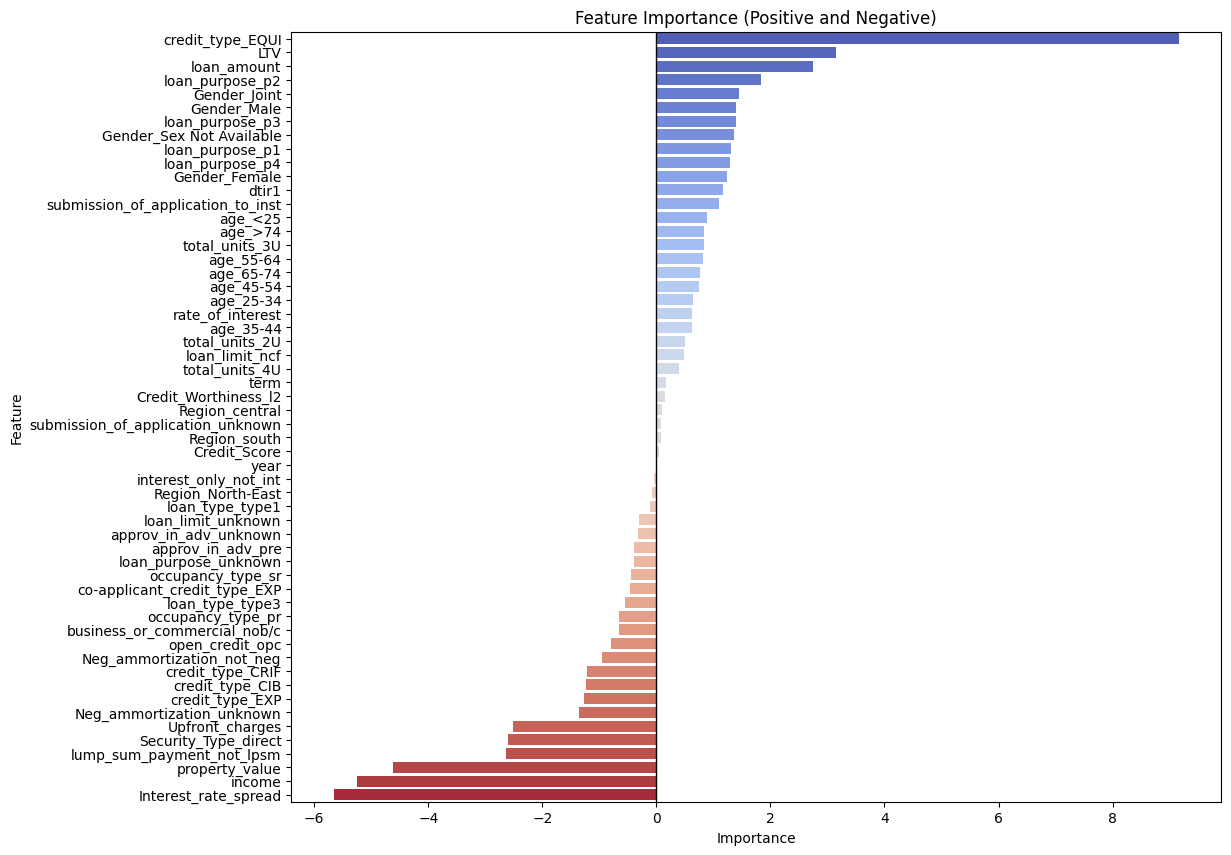

In [ ]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Get feature names and coefficients (without taking the absolute value)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': log_reg.coef_[0]})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.axvline(0, color='black',linewidth=1)  # Add a vertical line at 0 to separate negative and positive sides
plt.title('Feature Importance (Positive and Negative)')
plt.show()


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Convert column names to strings and replace invalid characters with a single underscore
x_train.columns = x_train.columns.astype(str).str.replace('[\[\]\<]+', '_', regex=True)
x_test.columns = x_test.columns.astype(str).str.replace('[\[\]\<]+', '_', regex=True)

import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

# Instantiate the XGBClassifier
xg_cl = xgb.XGBClassifier(random_state=1)

# Perform cross-validation
cv_scores_accuracy = cross_val_score(xg_cl, x_train, y_train, cv=5, scoring='accuracy')
cv_scores_f1 = cross_val_score(xg_cl, x_train, y_train, cv=5, scoring='f1')

# Fit the model on the full training set
xg_cl.fit(x_train, y_train)
preds = xg_cl.predict(x_test)
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)

# Display cross-validation results
print("Cross-Validation Accuracy Scores:", cv_scores_accuracy)
print("Mean Cross-Validation Accuracy:", cv_scores_accuracy.mean())
print("Cross-Validation F1 Scores:", cv_scores_f1)
print("Mean Cross-Validation F1:", cv_scores_f1.mean())

# Display test set metrics
print("Test Set Accuracy:", accuracy)
print("Test Set F1 Score:", f1)

Cross-Validation Accuracy Scores: [1.         1.         1.         1.         0.99997209]
Mean Cross-Validation Accuracy: 0.9999944183969636
Cross-Validation F1 Scores: [1.         1.         1.         1.         0.99997209]
Mean Cross-Validation F1: 0.9999944185527306
Test Set Accuracy: 0.9999663684670748
Test Set F1 Score: 0.9999313705305058


# Accuracy Evaluation

In [ ]:
accuracy_score(y_test,y_pred)

0.9999663684670748

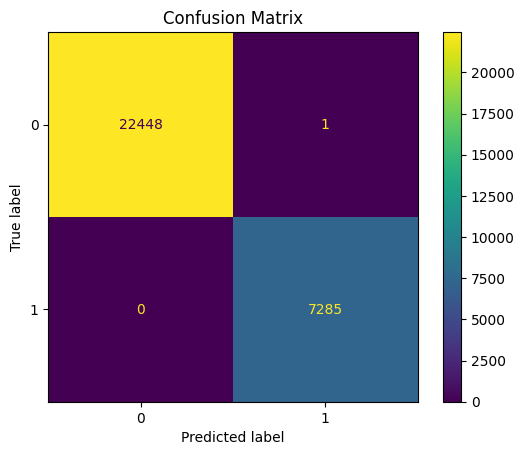

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Specify the labels (0, 1) or use your specific classes
disp.plot()

# Show the plot
plt.title("Confusion Matrix")
plt.show()



**So, we are getting approximately 99% accuracy**
